In [1]:
# general imports

import os
import sys
import itertools
sys.path.append(os.path.expanduser('~/PythonModules/Own'))

import seaborn as sns
import numpy as np
import scipy.signal as sig
import scipy.constants as csts
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

# importing own packages and methods

import fitting_functions as func

from plotting import *

# notebook setup

set_sns_standard(context='talk')

%matplotlib inline 

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# import list with residue names
residue_names = []
with open('../working_files/residues_WW.txt') as f:
    for line in f:
        index, name = line.split()
        residue_names.append(index+' '+name)
        
print(residue_names)

['1 LYS', '2 LEU', '3 PRO', '4 PRO', '5 GLY', '6 TRP', '7 GLU', '8 AHA', '9 ARG', '10 MET', '11 SER', '12 ARG', '13 SER', '14 SER', '15 GLY', '16 ARG', '17 VAL', '18 TYR', '19 AZU', '20 PHE', '21 ASN', '22 HIS', '23 ILE', '24 THR', '25 ASN', '26 ALA', '27 SER', '28 GLN', '29 TRP', '30 GLU', '31 ARG', '32 PRO', '33 SER', '34 GLY']


In [3]:
def plot_E_kin(E_kin_array, time, plotlabels, saveroot='E_kin_MD', E_kin_model=None, t_model=None, log=True):
    fig = plt.figure(figsize=(10,6))
    axe = fig.add_subplot(111)
    
    for i, e_kin in enumerate(E_kin_array):
        lineplot = axe.plot(time, e_kin-e_kin[0], label=plotlabels[i])
        
        if type(E_kin_model) != type(None):
            axe.plot(t_model, E_kin_model[i]-E_kin_model[i,0], '--', color = lineplot[0].get_color())
    
    if log:
        axe.set_xscale('log')
    axe.legend()
    axe.set_xlabel('t / ps')
    axe.set_ylabel('E$_{kin}$ / kJ mol$^{-1}$')
    
    if type(E_kin_model) == type(None): 
        axe.set_xlim(xmin=min(time), xmax=max(time))
    elif type(E_kin_model) == type(np.zeros(0)):
        axe.set_xlim(xmin=min(t_model), xmax=max(t_model))

    
    savename = '/home/thiele/Documents/Physik/HiWi/WW/Plots/' + saveroot
    for resname in plotlabels:
        savename += '_{0}'.format(resname.replace(' ', ''))
    if not log:
        savename += '_lin'
    savename += '.pdf'
    
    fig.tight_layout()
    fig.savefig(savename)

# MD Data

In [ ]:
E_kin_MD = np.load('../working_files/E_kin_all_residues_average.npy')/100 # divide by 100 due to MDanalysis units
t = np.load('../working_files/time_scale.npy')
time_MD = t

# apply savitzki golay filter to data
'''exponential_intervals = [0]
exponential_intervals += [10**i for i in range(1, int(round(np.log10(len(E_kin_MD[0])))))]

for ekin in E_kin_MD:
    for i in range(len(exponential_intervals)-1):
        if i < len(exponential_intervals)-2:
            index1 = exponential_intervals[i]
            index2 = exponential_intervals[i+1]
            ekin_unfiltered = ekin[index1:index2]
            ekin_filtered = sig.savgol_filter(ekin_unfiltered, 5**(i+1), 4)
            ekin[index1:index2] = ekin_filtered
            
        elif i == len(exponential_intervals)-2:
            index1 = exponential_intervals[i]
            ekin_unfiltered = ekin[index1:]
            ekin_filtered = sig.savgol_filter(ekin_unfiltered, 5**(i+1), 4)
            ekin[index1:] = ekin_filtered'''


plotlabels = residue_names[1:]

    
plot_E_kin(E_kin_MD[15:17], t, plotlabels[15:17])

plot_E_kin(E_kin_MD[17:18], t, plotlabels[17:18])

plot_E_kin(E_kin_MD[18:23], t, plotlabels[18:23])

plot_E_kin(E_kin_MD[23:26], t, plotlabels[23:26])


plot_E_kin(E_kin_MD[5:9], t, plotlabels[5:9])

plot_E_kin(E_kin_MD[26:], t, plotlabels[26:])

plot_E_kin(E_kin_MD[17:18, :1000], t[:1000], plotlabels[17:18], log=False)
plot_E_kin(E_kin_MD[15:17], t, plotlabels[15:17], log=False)


# total energy of peptide
plot_E_kin([np.sum(E_kin_MD, axis=0)[:1000]], time_MD[:1000], plotlabels=['Total energy'], saveroot='E_kin_tot_MD')


# MEQ Results

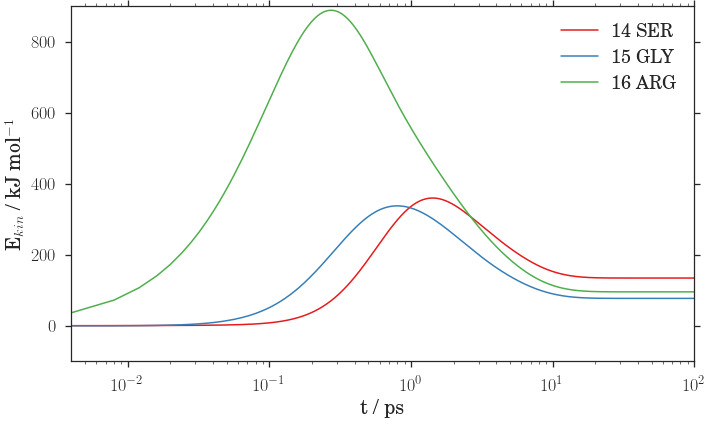

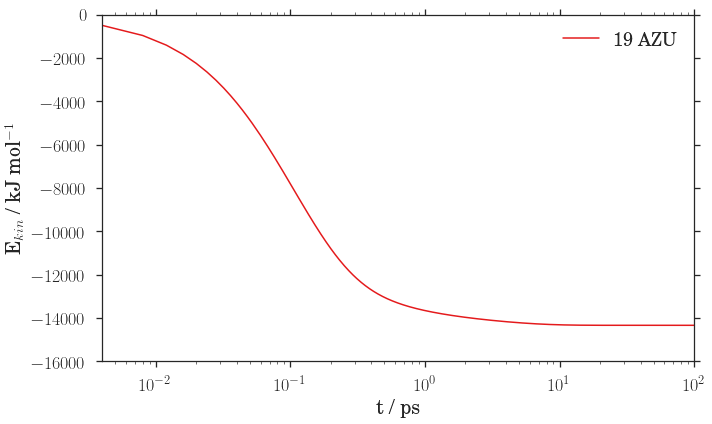

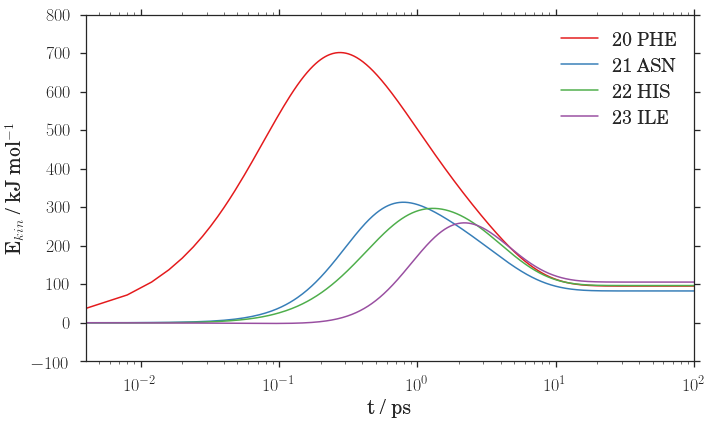

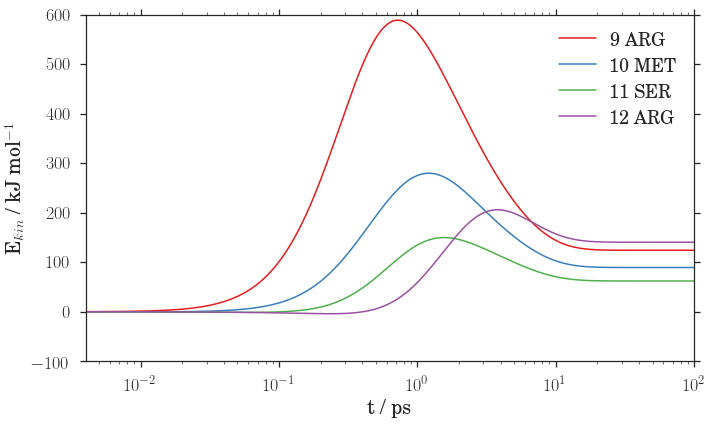

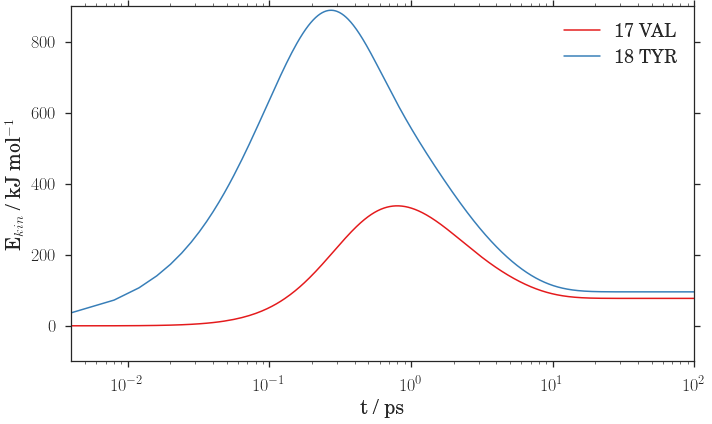

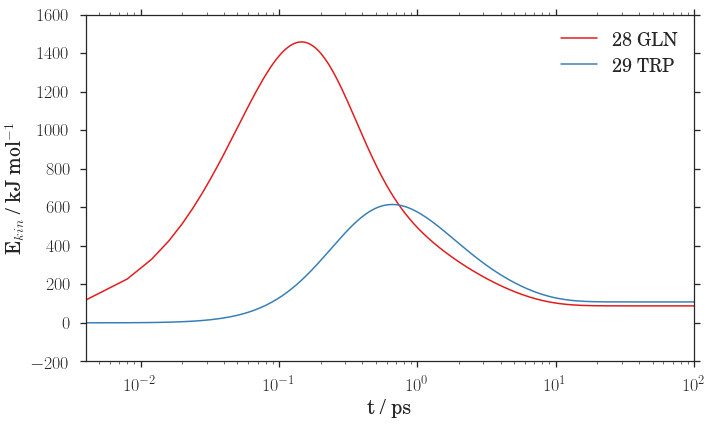

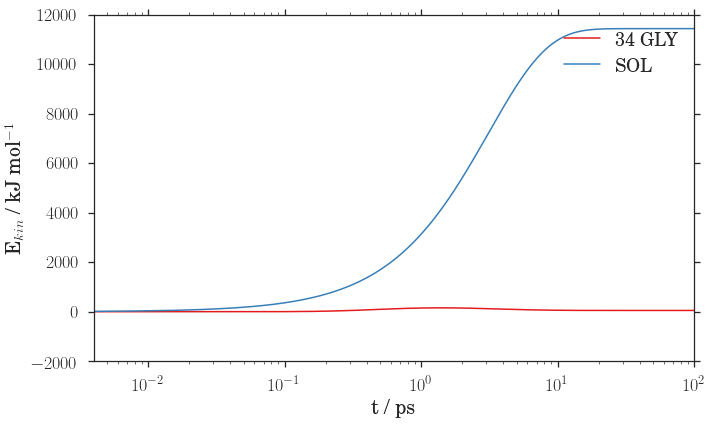

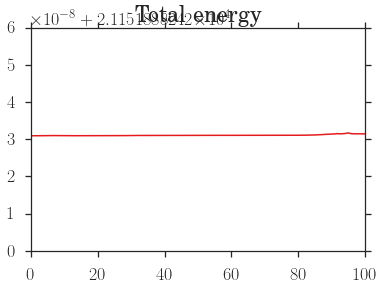

In [73]:
E_kin_MEQ = np.load('../working_files/E_kin_all_residues_MEQ.npy')/100

scaling = max(E_kin_MEQ[:,0])/max(E_kin_MD[:,0])
#E_kin_MEQ /= scaling

labels = residue_names + ['SOL']

t = np.linspace(0, 100, len(E_kin_MEQ[0]))
time_MEQ = t
#print(np.where(E_kin_MEQ[:,0]>2000)[0])

plot_E_kin(E_kin_MEQ[15:18], t, labels[13:18], saveroot='E_kin_MEQ')
plot_E_kin(E_kin_MEQ[18:19], t, labels[18:19], saveroot='E_kin_MEQ')
plot_E_kin(E_kin_MEQ[19:23], t, labels[19:23], saveroot='E_kin_MEQ')
plot_E_kin(E_kin_MEQ[8:12], t, labels[8:12], saveroot='E_kin_MEQ')
plot_E_kin(E_kin_MEQ[16:18], t, labels[16:18], saveroot='E_kin_MEQ')
plot_E_kin(E_kin_MEQ[27:29], t, labels[27:29], saveroot='E_kin_MEQ')


plot_E_kin(E_kin_MEQ[-2:], t, labels[-2:], saveroot='E_kin_MEQ')

fig = plt.figure()
axe = fig.add_subplot(111)
axe.plot(t, np.sum(E_kin_MEQ, axis=0))
axe.set_title('Total energy')

# Comparison of MD and MEQ

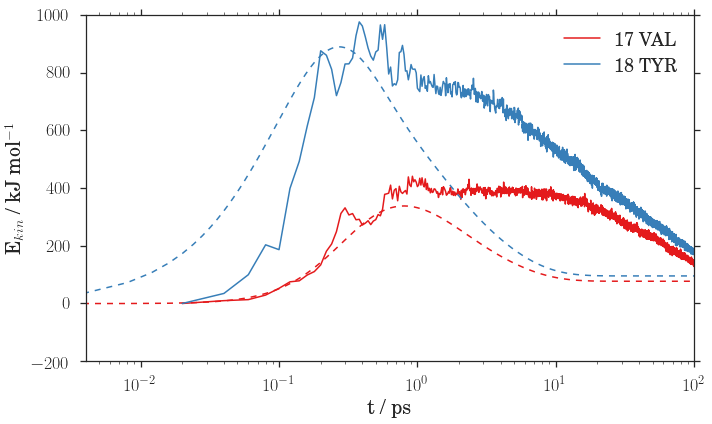

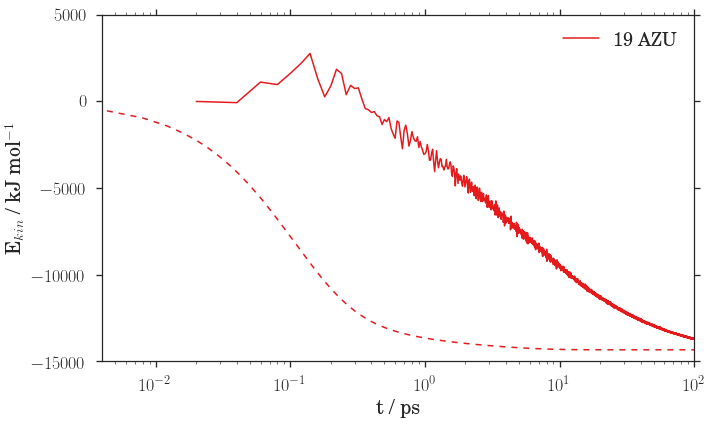

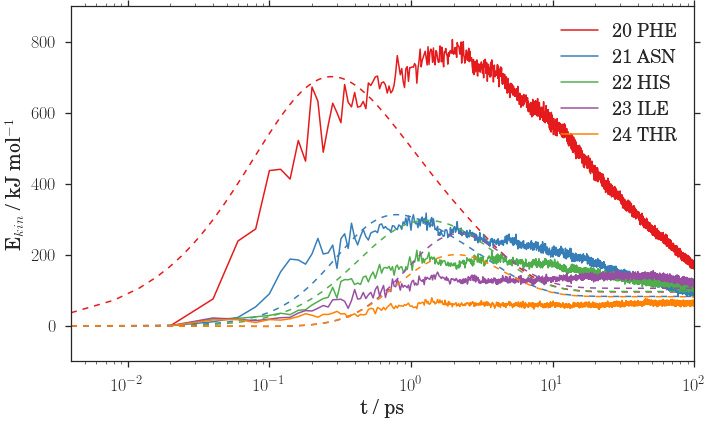

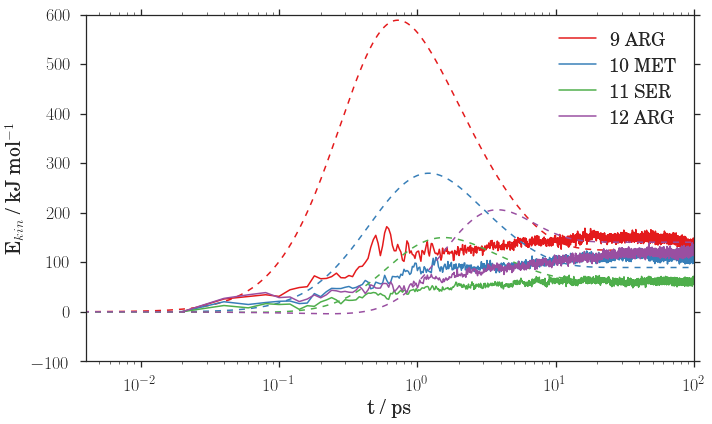

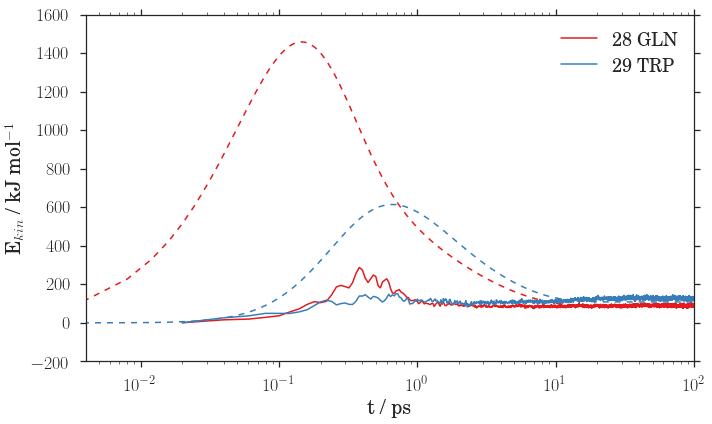

In [74]:
plot_E_kin(E_kin_MD[15:17], time_MD, plotlabels[15:17], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[16:18], t_model=time_MEQ)
plot_E_kin(E_kin_MD[17:18], time_MD, plotlabels[17:18], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[18:19], t_model=time_MEQ)
plot_E_kin(E_kin_MD[18:23], time_MD, plotlabels[18:23], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[19:24], t_model=time_MEQ)
plot_E_kin(E_kin_MD[7:11], time_MD, plotlabels[7:11], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[8:12], t_model=time_MEQ)
plot_E_kin(E_kin_MD[26:], time_MD, plotlabels[26:], saveroot='E_kin_MEQ_MD', E_kin_model=E_kin_MEQ[27:29], t_model=time_MEQ)


1.08940892435e+12 0.0 1.03710326224e+12
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.20391607e+12   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.23011155e+12   3.15904764e+12   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.62972386e+11
   0.00000000e+00   0.00000000e+00]


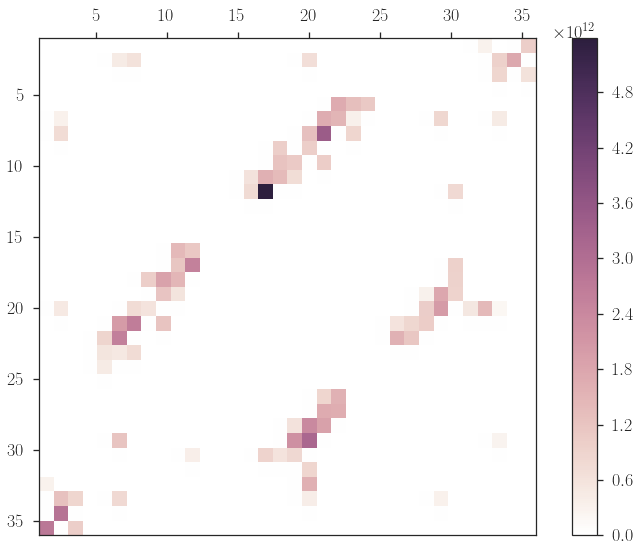

In [66]:
polar_rates_matrix = np.load('../working_files/polar_rates_matrix.npy')
axis = np.arange(1,37, 5)

def plot_matrix(matrix, xticklabels, yticklabels):
    fig = plt.figure(figsize=(10,10))
    axe = fig.add_subplot(111, aspect=1.0)

    mappable = axe.imshow(matrix, extent = [min(xticklabels), max(xticklabels), max(yticklabels), min(yticklabels)], cmap = sns.cubehelix_palette(light=1, as_cmap=True), interpolation='none')
    
    axe.xaxis.tick_top()
    axe.yaxis.tick_left()
    
    divider = make_axes_locatable(axe)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    plt.colorbar(mappable, cax=cax)
    
    return fig
    
    
print(polar_rates_matrix[8,17], polar_rates_matrix[8,18], polar_rates_matrix[8,19])
print(polar_rates_matrix[27,:])
    
fig = plot_matrix(polar_rates_matrix, xticklabels=axis, yticklabels=axis)
fig.savefig('../Plots/polar_rates_matrix.png')

1053665517176.4219

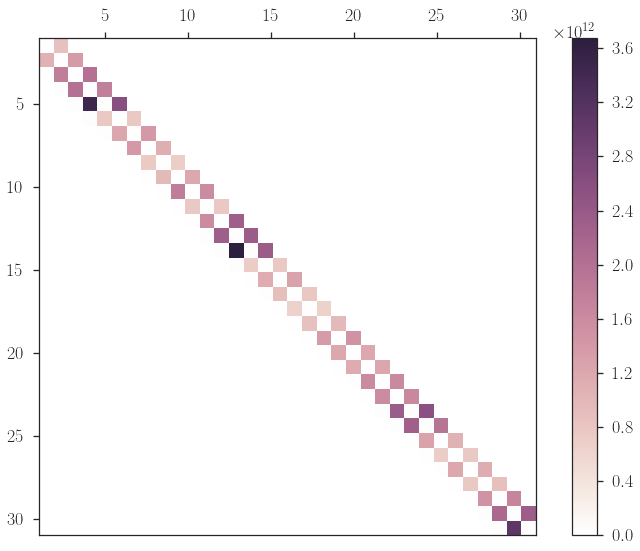

In [54]:
bonded_rates_matrix = np.load('../working_files/bonded_rates_matrix.npy')
axis = np.arange(1,35)

polar_rates_matrix = np.load('../working_files/polar_rates_matrix.npy')
axis = np.arange(1,36, 5)
  
fig = plot_matrix(bonded_rates_matrix, xticklabels=axis, yticklabels=axis)
fig.savefig('../Plots/bonded_rates_matrix.pdf')

bonded_rates_matrix[27, 28]

In [55]:
k_B = csts.Boltzmann
mol = csts.physical_constants['Avogadro constant'][0]

ekin = 60 * 67/2*k_B*910*mol/1000
print(ekin)

# approximate temperature of valine at begining.
180/k_B/mol*1000*2/39/19

15207.982710277262


58.43191670298576